# Malakal Sea Level Trend

This work is based on the Pacific Islands Climate Change Monitor 2021 Report. Original code was provided by Matthew Widlansky (UH Sea Level Center). Notebook received from Ayesha Genz

Access report: https://urldefense.com/v3/__https://www.pacificmet.net/sites/default/files/inline-files/documents/EWC*20PCCM*202022*20Report*20Final*20508_0.pdf__;JSUlJSU!!PvDODwlR4mBZyAb0!UGnZW_HZruUS4RnCWUhwAqVaB6b7UdkY02TRicvsE7bOVG200U0IRHCtjEqpst-HHIDTPRnvdw3-xKMeQU5a$ 

In [203]:
import xarray as xr
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
from urllib.request import urlretrieve
from pycurrents.data.timetools import dt64_to_ymdhms

## Access Malakal Data from UHSLC

In [204]:
#Access Malakal Data
datadir = './'
url = "https://uhslc.soest.hawaii.edu/data/netcdf/fast/hourly/%5C%22%5Cn%22fname = "h007.nc"
path = os.path.join(datadir, fname)

if not os.path.exists(path):
    urlretrieve(os.path.join(url, fname), path)
    
data_xr = xr.open_dataset(fname)
data_xr

<xarray.Dataset>
Dimensions:               (record_id: 1, time: 474393)
Coordinates:
  * time                  (time) datetime64[ns] 1969-05-18T15:00:00 ... 2023-...
  * record_id             (record_id) int16 70
Data variables:
    sea_level             (record_id, time) float32 ...
    lat                   (record_id) float32 ...
    lon                   (record_id) float32 ...
    station_name          (record_id) |S7 ...
    station_country       (record_id) |S5 ...
    station_country_code  (record_id) float32 ...
    uhslc_id              (record_id) int16 ...
    gloss_id              (record_id) float32 ...
    ssc_id                (record_id) |S4 ...
    last_rq_date          (record_id) datetime64[ns] ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2023-08-28T14:34:57Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          https://urldefense.com/v3/__http://uhslc.soest.hawaii.edu*5Cn__;JQ!!PvDODwlR4mBZyAb0!UGnZW_HZruUS4RnCWUhwAqVaB6b7UdkY02TRicvsE7bOVG200U0IRHCtjEqpst-HHIDTPRnvdw3-xCK9_Kcx$     summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

### Plot full time series

Text(0.5, 0.98, 'Malakal: Full Time Series')

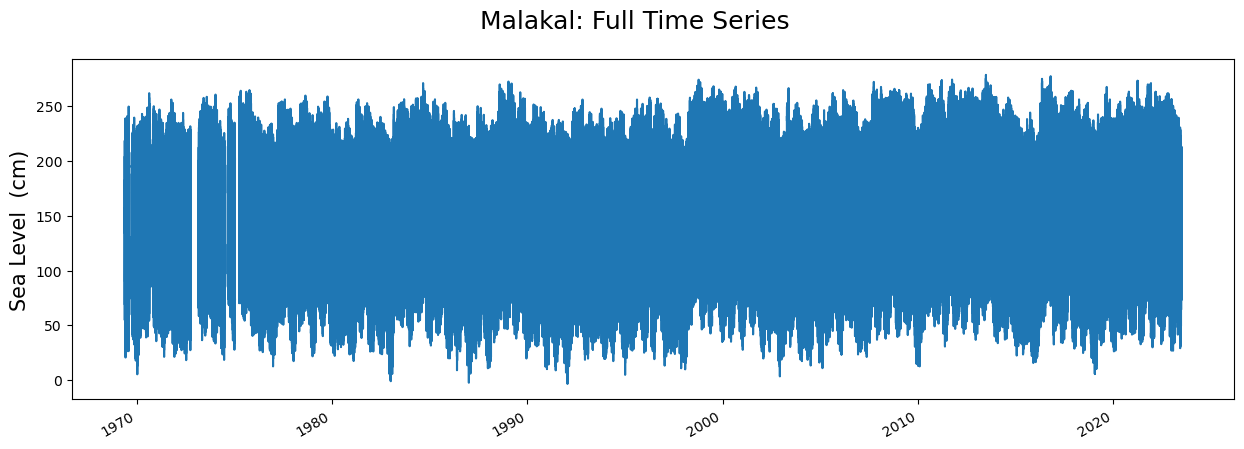

In [205]:
fig, ax = plt.subplots(sharex=True,figsize=[15,5])
fig.autofmt_xdate()
ax.plot(data_xr.time.values,data_xr.sea_level.T.values/10)

ax.set_ylabel('Sea Level  (cm)',fontsize=15)
fig.suptitle("Malakal: Full Time Series",fontsize=18)

## Identify epoch for the trend analysis

Calculate trend for the 1993-2022 epoch

In [206]:
#get data between 1993 and 2022
epoch = [1993,2022]
epoch_start = f"{epoch[0]}-01-01"
epoch_end = f"{epoch[-1]}-12-31"

data_epoch= data_xr.sel(dict(time=slice(epoch_start, epoch_end)))
data_epoch['sea_level'] = data_epoch.sea_level/10 #convert mm to cm
data_epoch

<xarray.Dataset>
Dimensions:               (record_id: 1, time: 262968)
Coordinates:
  * time                  (time) datetime64[ns] 1993-01-01 ... 2022-12-31T22:...
  * record_id             (record_id) int16 70
Data variables:
    sea_level             (record_id, time) float32 147.6 167.0 ... 135.3 127.0
    lat                   (record_id) float32 7.33
    lon                   (record_id) float32 134.5
    station_name          (record_id) |S7 b'Malakal'
    station_country       (record_id) |S5 b'Palau'
    station_country_code  (record_id) float32 585.0
    uhslc_id              (record_id) int16 7
    gloss_id              (record_id) float32 120.0
    ssc_id                (record_id) |S4 b'mala'
    last_rq_date          (record_id) datetime64[ns] 2018-12-31T22:59:59.971200
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2023-08-28T14:34:57Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          https://urldefense.com/v3/__http://uhslc.soest.hawaii.edu*5Cn__;JQ!!PvDODwlR4mBZyAb0!UGnZW_HZruUS4RnCWUhwAqVaB6b7UdkY02TRicvsE7bOVG200U0IRHCtjEqpst-HHIDTPRnvdw3-xCK9_Kcx$     summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

## Calculate Sea Level Trend

In [207]:
# Create 4-D array
dat_yyyymmddhh = np.full(((epoch[-1] - epoch[0]) + 1, 12, 31, 24), np.nan)

# Station start dates
ymdhms = dt64_to_ymdhms(data_epoch.time.values)
yyyy_start, mm_start, dd_start, hh_start = ymdhms[0,:4]
f'Start Date:  {yyyy_start}-{mm_start}-{dd_start} {hh_start}h'


'Start Date:  1993-1-1 0h'

In [208]:
# Account for Leap Year
daysInMonth_noLeap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
daysInMonth_Leap = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

time_station = 0
yyyy_uni_ct = 0

for yyyy_uni in range(epoch[0],epoch[-1]+1):
    yyyy_uni_ct += 1
    
    # Leap YR Adjustment
    if ((yyyy_uni % 4 == 0) and (yyyy_uni % 100 != 0)) or (yyyy_uni % 400 == 0):
        calendar = daysInMonth_Leap
    else:
        calendar = daysInMonth_noLeap
    
    for mm_uni in range(1, 13):
        for dd_uni in range(1, calendar[mm_uni - 1] + 1):
            for hh_uni in range(1, 25):
                date_uni = datetime(yyyy_uni, mm_uni, dd_uni)
                date_start = datetime(yyyy_start, mm_start, dd_start)
                if (date_uni >= date_start) and (time_station < data_epoch.sea_level.shape[1]):
                    time_station += 1
                    dat_yyyymmddhh[yyyy_uni_ct - 1, mm_uni - 1, dd_uni - 1, hh_uni - 1] = data_epoch.sea_level.values.T[time_station - 1,0]
                else:
                    dat_yyyymmddhh[yyyy_uni_ct - 1, mm_uni - 1, dd_uni - 1, hh_uni - 1] = np.nan

In [209]:
# Calculate Monthly Mean (yyyy,mm)
dat_yyyymm = np.nanmean(np.nanmean(dat_yyyymmddhh, axis=3), axis=2)

# Climatology 
dat_annual_climo = np.nanmean(dat_yyyymm,axis=0)
f"Annual Climatology: {dat_annual_climo}"


/tmp/ipykernel_844785/3531435719.py:2: RuntimeWarning: Mean of empty slice
  dat_yyyymm = np.nanmean(np.nanmean(dat_yyyymmddhh, axis=3), axis=2)


'Annual Climatology: [148.98240593 149.00314749 153.32659941 155.37251852 155.66522013\n 158.71701267 161.07816394 163.86426527 165.16034897 163.12276587\n 158.36997163 153.53608221]'

In [210]:
# Calculate Monthly Anomalies
time_ct = 0
dat_ANOM_yymm = np.zeros_like(dat_yyyymm)
dat_ANOM_time = np.zeros((dat_yyyymm.shape[0] * dat_yyyymm.shape[1], 1))
dat_yyyymm_time = np.zeros((dat_yyyymm.shape[0] * dat_yyyymm.shape[1], 1))

for yr_ct in range(dat_yyyymm.shape[0]):
    for mn_ct in range(dat_yyyymm.shape[1]):
        tmp_RAW = dat_yyyymm[yr_ct, mn_ct]
        tmp_CLIMO = dat_annual_climo[mn_ct]
        dat_ANOM_yymm[yr_ct, mn_ct] = tmp_RAW - tmp_CLIMO
        dat_ANOM_time[time_ct, 0] = dat_ANOM_yymm[yr_ct, mn_ct]
        dat_yyyymm_time[time_ct, 0] = dat_yyyymm[yr_ct, mn_ct]
        time_ct += 1
    


### Plot Monthly Means and Anomalies

Text(0.5, 0.98, 'Malalkal: Time Series of Monthly Means and Anomalies')

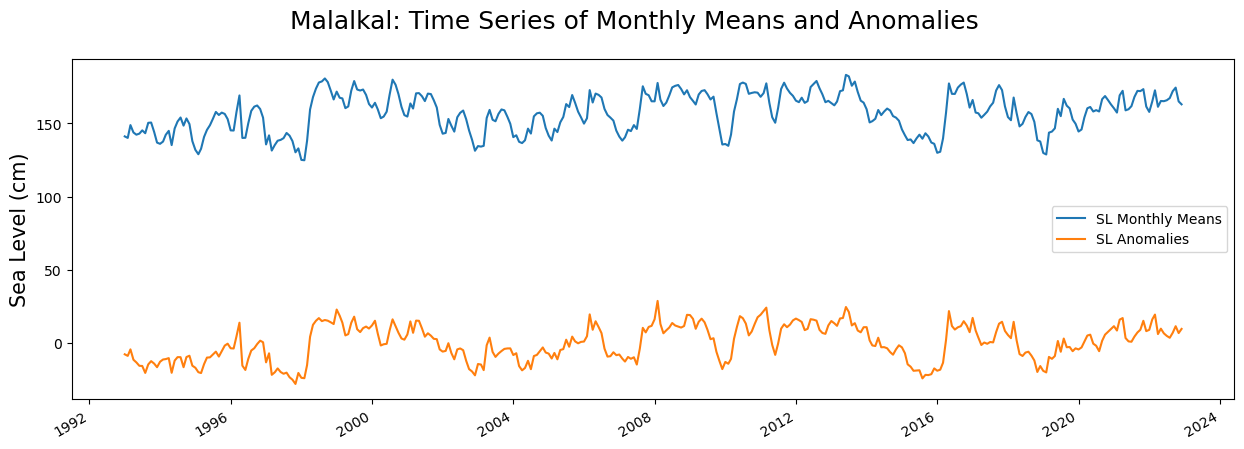

In [211]:
start_date = np.datetime64('1993-01')
end_date = np.datetime64('2023-01')
time_array = np.arange(start_date,end_date,dtype='datetime64[M]')

fig, ax = plt.subplots(sharex=True,figsize=[15,5])
fig.autofmt_xdate()
ax.plot(time_array,dat_yyyymm_time,label = 'SL Monthly Means')
ax.plot(time_array,dat_ANOM_time,label = 'SL Anomalies')
ax.legend()
ax.set_ylabel('Sea Level (cm)',fontsize=15)
fig.suptitle("Malalkal: Time Series of Monthly Means and Anomalies",fontsize=18)


In [212]:
# function to detrend with data containing NaNs

def detrend_NaN(x):
    # Reshape x if necessary, assuming the dimension to be detrended is the first
    szx = x.shape
    ndimx = len(szx)
    if ndimx > 2:
        x = x.reshape(szx[0], np.prod(szx[1:ndimx]))

    n = x.shape[0]
    if n == 1:
        x = x.reshape(-1)  # If a row, turn into column vector

    N, m = x.shape
    y = np.full((N, m), np.nan)

    for i in range(m):
        kp = np.where(~np.isnan(x[:, i]))[0]
        a = np.vstack([(kp - 1) / (max(kp) - min(kp)), np.ones(len(kp))]).T  # Build regressor
        y[kp, i] = x[kp, i] - np.linalg.lstsq(a, x[kp, i], rcond=None)[0] @ a.T

    if n == 1:
        y = y.T

    # Reshape output so it is the same dimension as input
    if ndimx > 2:
        y = y.reshape(szx)

    return y



In [213]:
# detrend data
no_trend_TG = detrend_NaN(dat_ANOM_time)

#offset
offset_TG = no_trend_TG - dat_ANOM_time

#trend
trend_TG = dat_ANOM_time - no_trend_TG

Trendval = trend_TG[-1] - trend_TG[0]

### Plot SL Trend


Text(0.25, 0.75, 'Trend = [12.011] cm/epoch')

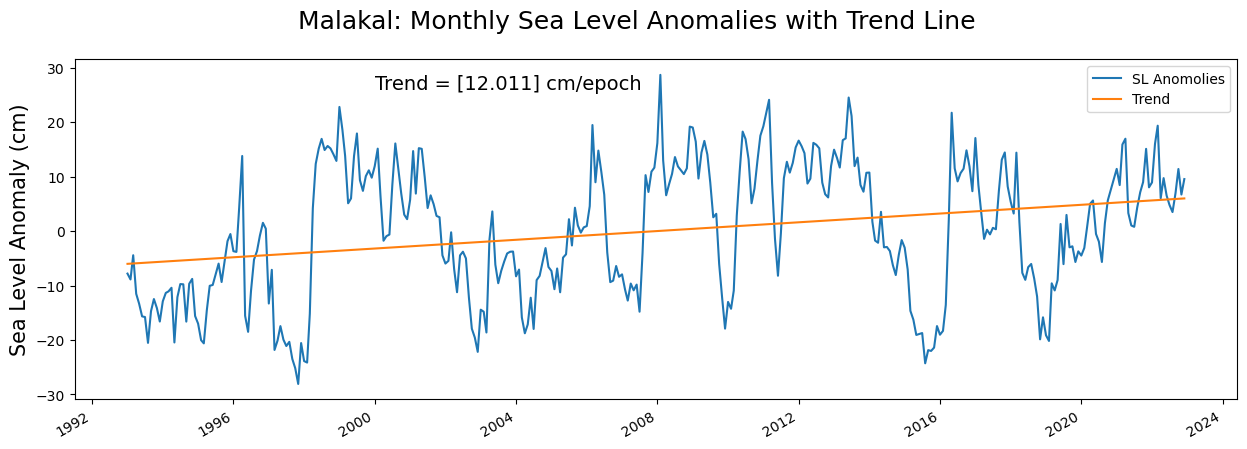

In [214]:
fig, ax = plt.subplots(sharex=True,figsize=[15,5])
fig.autofmt_xdate()
ax.plot(time_array,dat_ANOM_time,label = 'SL Anomolies')
ax.plot(time_array,trend_TG,label = 'Trend')
ax.legend()
ax.set_ylabel('Sea Level Anomaly (cm)',fontsize=15)
fig.suptitle("Malakal: Monthly Sea Level Anomalies with Trend Line",fontsize=18)
ax.annotate(f'Trend = {np.round(Trendval,3)} cm/epoch',xy=(.25,.75),xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',fontsize=14)